Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2 as cv

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
NUM_FEATURES = 2048
MAX_SEQ_LENGTH = 40
IMG_SIZE = 456

EPOCHS = 500

In [4]:
df = pd.read_csv('Labels.csv')
df = df.rename(columns={'Inefction_type':'infection'})
df.head()

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315


In [5]:
test = df[(df['Patient']==8)]
test

,Video_Num,infection,Patient,Patient_id
12,21,ca,8,20180918
13,22,cg,8,20180918
14,23,mock,8,20180918


In [6]:
train = pd.concat([df, test]).drop_duplicates(keep=False)
train

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315
5,6,mock,2,20180315
6,13,ca,5,20180409
7,14,cg,5,20180409
8,15,mock,5,20180409
9,18,ca,7,20180914


In [7]:
def concat_arrays(df):

    full_features = []
    full_labels = []

    for i,item in df.iterrows():
    
        features = np.load(f'/asbdata/Arjun/Bloodi/Patch_videos_numpy/videos/{item[0]}_features.npy')
        labels = np.load(f'/asbdata/Arjun/Bloodi/Patch_videos_numpy/labels/{item[0]}_labels.npy')
    
        full_features.extend(features)
        full_labels.extend(labels)
    
    final_features = np.array(full_features)
    final_labels = np.array(full_labels)
    
    return final_features,final_labels

In [8]:
train_data, train_labels = concat_arrays(train)
test_data, test_labels = concat_arrays(test)


print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(1152, 40, 2048)
(1152, 1)
(144, 40, 2048)
(144, 1)


In [9]:
with strategy.scope():

    def get_compiled_model():
        
        frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))

        x = keras.layers.GRU(128, return_sequences=True)(frame_features_input)
        x = keras.layers.GRU(64)(x)
        x = keras.layers.Dropout(0.4)(x)
        x = keras.layers.Dense(64, activation="relu")(x)
        output = keras.layers.Dense(3, activation="softmax")(x)

        rnn_model = keras.Model(frame_features_input, output)

        rnn_model.compile(
            loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
        )
        
        rnn_model.summary()
        
        return rnn_model
    
with strategy.scope():
    
    def run_experiment():
        
        filepath = "lstm_5.h5"
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, verbose=1)
        stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=1,mode='auto')

        model = get_compiled_model()
        history = model.fit(
            train_data,
            train_labels,
            validation_split=0.1,
            epochs=EPOCHS,
            callbacks=[checkpoint,stopping,reduce_lr],
        )

        model.load_weights(filepath)
        _, accuracy = model.evaluate(test_data, test_labels)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")

        return model

In [10]:
trained_model = run_experiment()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 2048)]        0         
                                                                 
 gru (GRU)                   (None, 40, 128)           836352    
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 877,955
Trainable params: 877,955
Non-trainable

Epoch 24/500
32/33 [============================>.] - ETA: 0s - loss: 4.2669e-04 - accuracy: 1.0000
Epoch 24: val_loss improved from 0.00014 to 0.00012, saving model to lstm_5.h5
33/33 [==============================] - 0s 13ms/step - loss: 4.2301e-04 - accuracy: 1.0000 - val_loss: 1.2069e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 25/500
28/33 [========================>.....] - ETA: 0s - loss: 3.7296e-04 - accuracy: 1.0000
Epoch 25: val_loss improved from 0.00012 to 0.00010, saving model to lstm_5.h5
33/33 [==============================] - 0s 15ms/step - loss: 3.6299e-04 - accuracy: 1.0000 - val_loss: 1.0323e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 26/500
30/33 [==========================>...] - ETA: 0s - loss: 3.2723e-04 - accuracy: 1.0000
Epoch 26: val_loss improved from 0.00010 to 0.00009, saving model to lstm_5.h5
33/33 [==============================] - 0s 14ms/step - loss: 3.2909e-04 - accuracy: 1.0000 - val_loss: 9.4386e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 27/5

33/33 [==============================] - 0s 13ms/step - loss: 1.2540e-04 - accuracy: 1.0000 - val_loss: 2.8562e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 49/500
32/33 [============================>.] - ETA: 0s - loss: 1.1717e-04 - accuracy: 1.0000
Epoch 49: val_loss improved from 0.00003 to 0.00003, saving model to lstm_5.h5
33/33 [==============================] - 0s 14ms/step - loss: 1.1894e-04 - accuracy: 1.0000 - val_loss: 2.8332e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 50/500
32/33 [============================>.] - ETA: 0s - loss: 1.1497e-04 - accuracy: 1.0000
Epoch 50: val_loss improved from 0.00003 to 0.00003, saving model to lstm_5.h5
33/33 [==============================] - 0s 13ms/step - loss: 1.1429e-04 - accuracy: 1.0000 - val_loss: 2.8097e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 51/500
31/33 [===========================>..] - ETA: 0s - loss: 1.1373e-04 - accuracy: 1.0000
Epoch 51: val_loss improved from 0.00003 to 0.00003, saving model to lstm_5.h

Epoch 73/500
31/33 [===========================>..] - ETA: 0s - loss: 1.1878e-04 - accuracy: 1.0000
Epoch 73: val_loss did not improve from 0.00003
33/33 [==============================] - 0s 10ms/step - loss: 1.1753e-04 - accuracy: 1.0000 - val_loss: 2.7538e-05 - val_accuracy: 1.0000 - lr: 1.0000e-07
Epoch 74/500
33/33 [==============================] - ETA: 0s - loss: 1.1709e-04 - accuracy: 1.0000
Epoch 74: val_loss did not improve from 0.00003
33/33 [==============================] - 0s 9ms/step - loss: 1.1709e-04 - accuracy: 1.0000 - val_loss: 2.7538e-05 - val_accuracy: 1.0000 - lr: 1.0000e-07
Epoch 75/500
30/33 [==========================>...] - ETA: 0s - loss: 1.2446e-04 - accuracy: 1.0000
Epoch 75: val_loss did not improve from 0.00003
33/33 [==============================] - 0s 10ms/step - loss: 1.2575e-04 - accuracy: 1.0000 - val_loss: 2.7538e-05 - val_accuracy: 1.0000 - lr: 1.0000e-07
Epoch 76/500
32/33 [============================>.] - ETA: 0s - loss: 1.1610e-04 - accuracy:

33/33 [==============================] - 0s 9ms/step - loss: 1.2350e-04 - accuracy: 1.0000 - val_loss: 2.7536e-05 - val_accuracy: 1.0000 - lr: 1.0000e-09
Epoch 100/500
32/33 [============================>.] - ETA: 0s - loss: 1.2873e-04 - accuracy: 1.0000
Epoch 100: val_loss did not improve from 0.00003
33/33 [==============================] - 0s 9ms/step - loss: 1.2821e-04 - accuracy: 1.0000 - val_loss: 2.7536e-05 - val_accuracy: 1.0000 - lr: 1.0000e-09
Epoch 101/500
33/33 [==============================] - ETA: 0s - loss: 1.4099e-04 - accuracy: 1.0000
Epoch 101: val_loss did not improve from 0.00003

Epoch 101: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
33/33 [==============================] - 0s 9ms/step - loss: 1.4099e-04 - accuracy: 1.0000 - val_loss: 2.7536e-05 - val_accuracy: 1.0000 - lr: 1.0000e-09
Epoch 102/500
33/33 [==============================] - ETA: 0s - loss: 1.2825e-04 - accuracy: 1.0000
Epoch 102: val_loss did not improve from 0.00003
33/33 [==

In [11]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

5/5 [==============================] - 0s 4ms/step


([<matplotlib.axis.YTick at 0x7f3d281b6bb0>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

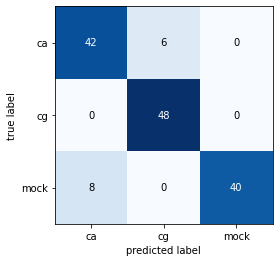

In [12]:
trained_model = tf.keras.models.load_model('lstm_5.h5')

predicted_vals = trained_model.predict(test_data).argmax(axis=1)

labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted_vals)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)